# Exploration and Comparison of Transformers for Image Classification

## Fine-tuning (optimized) using Vision Transformer (ViT)

Fine-tuning is an experiment that involves training the entire model on the new task. All of model's parameters are end-to-end fine-tuned on the provided dataset.

The resulting model's performance is the measured on the test split with accuracy metric.

TODO: talk about the optimalization + data aug

### Vision Transformer (ViT)

Vision Transformer (ViT) model pre-trained on ImageNet-21k (14 million images, 21,843 classes) at resolution 224x224, and fine-tuned on ImageNet 2012 (1 million images, 1,000 classes) at resolution 224x224. It was introduced in the paper *An Image is Worth 16x16 Words: Transformers for Image Recognition at Scale by Dosovitskiy et al.*

https://arxiv.org/abs/2010.11929

### Prerequisites

Load necessary packages.

In [2]:
import os

os.chdir("..")

import pandas as pd
import torch
from datasets import DatasetDict, load_dataset, concatenate_datasets
from src.dataset_builder import ImageDataset
from src.models import *
from src.train import *
from utils.config import *
from utils.data_utils import *
from utils.models_utils import *
from utils.train_utils import *
from utils.visualization_utils import *

Check if there is GPU available.

In [3]:
get_gpu_info()

GPU 0: NVIDIA A100 80GB PCIe
VRAM: 79.25 GB


Set manual seed for reproducibility.

In [4]:
id = 10
torch.manual_seed(10)

Load ViT image processor used for image pre-processing.

In [5]:
processor = get_backbone_processor(model_names["ViT"])

Print the pre-processing operations done by the processor.

In [6]:
processor

ViTImageProcessorFast {
  "do_convert_rgb": null,
  "do_normalize": true,
  "do_rescale": true,
  "do_resize": true,
  "image_mean": [
    0.5,
    0.5,
    0.5
  ],
  "image_processor_type": "ViTImageProcessorFast",
  "image_std": [
    0.5,
    0.5,
    0.5
  ],
  "resample": 2,
  "rescale_factor": 0.00392156862745098,
  "size": {
    "height": 224,
    "width": 224
  }
}

### Data Preprocessing

Load each dataset and its splits.

NOTE: For this experiment, a validation set is required. Since some of the datasets don't have one, it is necessary to create one from a part of the training set.

Processor is automatically applied to each image.

#### RESISC45

In [26]:
resisc45 = load_dataset("timm/resisc45")
clean_labels(resisc45, name="resisc45")
resisc45_train = ImageDataset(
    dataset=resisc45["train"],
    processor=processor,
)
resisc45_validation = ImageDataset(
    dataset=resisc45["validation"],
    processor=processor,
)
resisc45_test = ImageDataset(
    dataset=resisc45["test"],
    processor=processor,
)

In [27]:
resisc45

DatasetDict({
    train: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 18900
    })
    validation: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
    test: Dataset({
        features: ['image', 'label', 'image_id'],
        num_rows: 6300
    })
})

#### Food-101

In [9]:
food101 = load_dataset("ethz/food101")
clean_labels(food101, name="food101")

In [10]:
_food101 = food101["train"].train_test_split(test_size=0.333, seed=id)
food101 = DatasetDict(
    {
        "train": _food101["train"],
        "validation": _food101["test"],
        "test": food101["validation"],
    }
)

In [11]:
food101_train = ImageDataset(
    dataset=food101["train"],
    processor=processor,
)
food101_validation = ImageDataset(
    dataset=food101["validation"],
    processor=processor,
)
food_101_test = ImageDataset(
    dataset=food101["test"],
    processor=processor,
)

In [12]:
food101

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 50525
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 25225
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 25250
    })
})

#### FER2013

In [13]:
fer2013 = load_dataset("AutumnQiu/fer2013")
clean_labels(fer2013, name="fer2013")
fer2013_train = ImageDataset(
    dataset=fer2013["train"],
    processor=processor,
)
fer2013_validation = ImageDataset(
    dataset=fer2013["valid"],
    processor=processor,
)
fer2013_test = ImageDataset(
    dataset=fer2013["test"],
    processor=processor,
)

In [14]:
fer2013

DatasetDict({
    train: Dataset({
        features: ['label', 'image'],
        num_rows: 28709
    })
    valid: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
    test: Dataset({
        features: ['label', 'image'],
        num_rows: 3589
    })
})

#### PCam

In [15]:
pcam = load_dataset("zacharielegault/PatchCamelyon")
clean_labels(pcam, name="pcam")
pcam_train = ImageDataset(
    dataset=pcam["train"],
    processor=processor,
)
pcam_validation = ImageDataset(
    dataset=pcam["validation"],
    processor=processor,
)
pcam_test = ImageDataset(
    dataset=pcam["test"],
    processor=processor,
)

In [16]:
pcam

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 262144
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 32768
    })
})

#### SUN397

In [17]:
sun397 = load_dataset("dpdl-benchmark/sun397")
clean_labels(sun397, name="sun397")
sun397_train = ImageDataset(
    dataset=sun397["train"],
    processor=processor,
)
sun397_validation = ImageDataset(
    dataset=sun397["validation"],
    processor=processor,
)
sun397_test = ImageDataset(
    dataset=sun397["test"],
    processor=processor,
)

In [18]:
sun397

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 76127
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 21750
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 10875
    })
})

#### DTD

In [19]:
dtd = load_dataset("tanganke/dtd")
clean_labels(dtd, name="dtd")

In [20]:
_dtd = dtd["train"].train_test_split(test_size=0.1, seed=id)
dtd = DatasetDict(
    {
        "train": _dtd["train"],
        "validation": _dtd["test"],
        "test": dtd["test"],
    }
)

In [21]:
dtd_train = ImageDataset(
    dataset=dtd["train"],
    processor=processor,
)
dtd_validation = ImageDataset(
    dataset=dtd["validation"],
    processor=processor,
)
dtd_test = ImageDataset(
    dataset=dtd["test"],
    processor=processor,
)

In [22]:
dtd

DatasetDict({
    train: Dataset({
        features: ['image', 'label'],
        num_rows: 3384
    })
    validation: Dataset({
        features: ['image', 'label'],
        num_rows: 376
    })
    test: Dataset({
        features: ['image', 'label'],
        num_rows: 1880
    })
})

### Data Augmentation

TODO: text

In [28]:
augmentations = get_data_augmentations()
augmentations

Compose(
    RandomResizedCrop(size=(224, 224), scale=(0.7, 1.0), ratio=(0.75, 1.3333), interpolation=bilinear, antialias=True)
    RandomHorizontalFlip(p=0.5)
    RandomVerticalFlip(p=0.5)
    RandomInvert(p=0.5)
    RandomRotation(degrees=[-45.0, 45.0], interpolation=nearest, expand=False, fill=0)
    RandomAffine(degrees=[0.0, 0.0], translate=(0.1, 0.1), scale=(0.8, 1.2))
    GaussianBlur(kernel_size=(5, 5), sigma=(0.1, 2.0))
    ColorJitter(brightness=(0.7, 1.3), contrast=(0.7, 1.3), saturation=(0.7, 1.3), hue=(-0.3, 0.3))
)

#### RESISC45

In [29]:
sample = resisc45['train'].train_test_split(train_size=0.15, seed=id)['train']
resisc45_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [30]:
resisc45_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 2835/2835 [01:28<00:00, 31.90 examples/s]

Augmentation completed. Total number of new samples generated: 2835


In [31]:
resisc45_train_augmented = concatenate_datasets([resisc45_train.dataset, resisc45_train_sample.dataset])

In [32]:
resisc45_train = ImageDataset(
    dataset=resisc45_train_augmented,
    processor=processor,
)

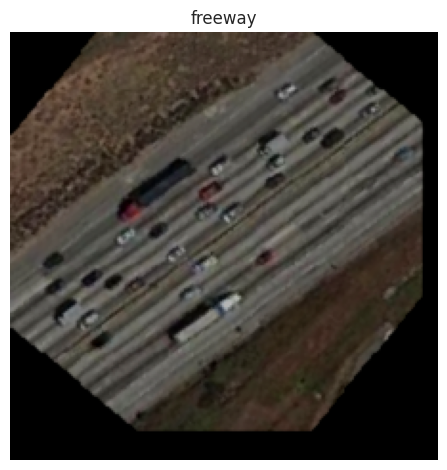

In [33]:
resisc45_train.plot_image(-1)

#### Food-101

In [34]:
sample = food101['train'].train_test_split(train_size=0.15, seed=id)['train']
food101_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [35]:
food101_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 7578/7578 [04:09<00:00, 30.40 examples/s]

Augmentation completed. Total number of new samples generated: 7578


In [36]:
food101_train_augmented = concatenate_datasets([food101_train.dataset, food101_train_sample.dataset])

In [37]:
food101_train = ImageDataset(
    dataset=food101_train_augmented,
    processor=processor,
)

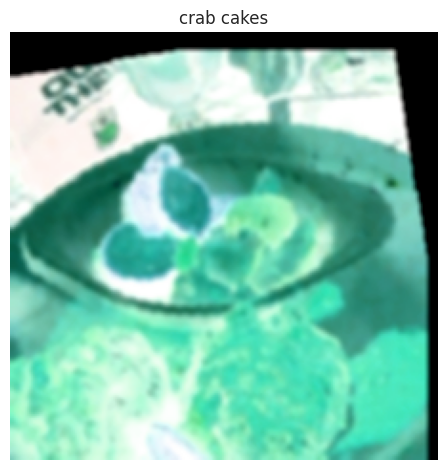

In [38]:
food101_train.plot_image(-1)

#### FER2013

In [39]:
sample = fer2013['train'].train_test_split(train_size=0.15, seed=id)['train']
fer2013_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [40]:
fer2013_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 4306/4306 [01:10<00:00, 61.36 examples/s]

Augmentation completed. Total number of new samples generated: 4306


In [41]:
fer2013_train_augmented = concatenate_datasets([fer2013_train.dataset, fer2013_train_sample.dataset])

In [42]:
fer2013_train = ImageDataset(
    dataset=fer2013_train_augmented,
    processor=processor,
)

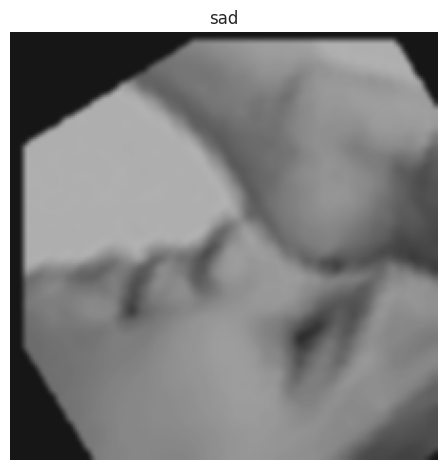

In [43]:
fer2013_train.plot_image(-1)

#### PCam

In [44]:
sample = pcam['train'].train_test_split(train_size=0.15, seed=id)['train']
pcam_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [45]:
pcam_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 39321/39321 [18:19<00:00, 35.75 examples/s]

Augmentation completed. Total number of new samples generated: 39321


In [46]:
pcam_train_augmented = concatenate_datasets([pcam_train.dataset, pcam_train_sample.dataset])

In [47]:
pcam_train = ImageDataset(
    dataset=pcam_train_augmented,
    processor=processor,
)

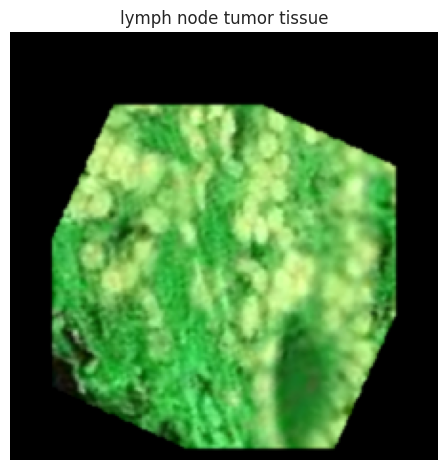

In [48]:
pcam_train.plot_image(-1)

#### SUN397

In [49]:
sample = sun397['train'].train_test_split(train_size=0.15, seed=id)['train']
sun397_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [50]:
sun397_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 11419/11419 [06:28<00:00, 29.38 examples/s]

Augmentation completed. Total number of new samples generated: 11419


In [51]:
sun397_train_augmented = concatenate_datasets([sun397_train.dataset, sun397_train_sample.dataset])

In [52]:
sun397_train = ImageDataset(
    dataset=sun397_train_augmented,
    processor=processor,
)

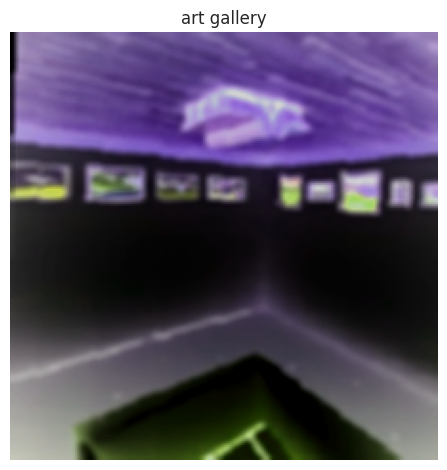

In [53]:
sun397_train.plot_image(-1)

#### DTD

In [54]:
sample = dtd['train'].train_test_split(train_size=0.15, seed=id)['train']
dtd_train_sample = ImageDataset(
    dataset=sample,
    processor=processor,
)

In [55]:
dtd_train_sample.augment_dataset(augmentations=augmentations, batch_size=32)

Map: 100%|██████████| 507/507 [00:16<00:00, 29.95 examples/s]

Augmentation completed. Total number of new samples generated: 507


In [56]:
dtd_train_augmented = concatenate_datasets([dtd_train.dataset, dtd_train_sample.dataset])

In [57]:
dtd_train = ImageDataset(
    dataset=dtd_train_augmented,
    processor=processor,
)

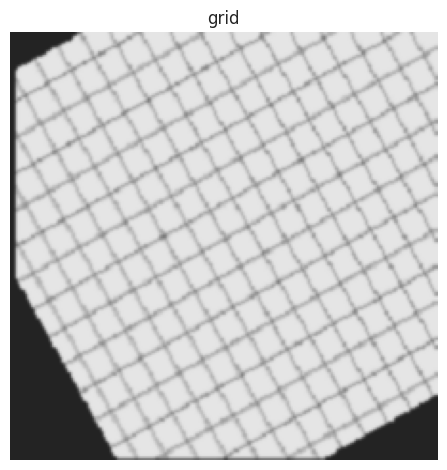

In [58]:
dtd_train.plot_image(-1)

### Config

Create a config for experiments and print its settings.

In [75]:
scheduler = SchedulerConfig(
    enabled=True,
    warmup_epochs=3,
    eta_min=1e-7,
    linear_start_factor=0.1,
    linear_end_factor=1.0
)
scheduler.get_scheduler_settings()

{'enabled': True,
 'warmup_epochs': 3,
 'eta_min': 1e-07,
 'linear_start_factor': 0.1,
 'linear_end_factor': 1.0}

In [76]:
gradient_clipping = GradientClippingConfig(
    enabled=True,
    max_norm=2.0
)
gradient_clipping.get_clipping_settings()

{'enabled': True, 'max_norm': 2.0}

In [77]:
early_stopping = EarlyStoppingConfig(
    enabled=True,
    patience=5,
    delta=0.005,
)
early_stopping.get_early_stopping_settings()

{'enabled': True, 'patience': 5, 'delta': 0.005}

In [78]:
from torch.optim import AdamW

config = Config(
    batch_size=64, 
    num_epochs=15, 
    lr=5e-5, 
    optimizer=AdamW, 
    weight_decay=1e-2,
    dropout_rate=0.5,
    early_stopping=early_stopping,
    gradient_clipping=gradient_clipping,
    scheduler=scheduler,
)
config.get_settings()

{'device': 'cuda',
 'criterion': CrossEntropyLoss(),
 'batch_size': 64,
 'lr': 5e-05,
 'num_epochs': 15,
 'optimizer': torch.optim.adamw.AdamW,
 'weight_decay': 0.01,
 'dropout_rate': 0.5,
 'early_stopping': {'enabled': True, 'patience': 5, 'delta': 0.005},
 'gradient_clipping': {'enabled': True, 'max_norm': 2.0},
 'scheduler': {'enabled': True,
  'warmup_epochs': 3,
  'eta_min': 1e-07,
  'linear_start_factor': 0.1,
  'linear_end_factor': 1.0}}

Plot the learning rate curve from scheduling settings.

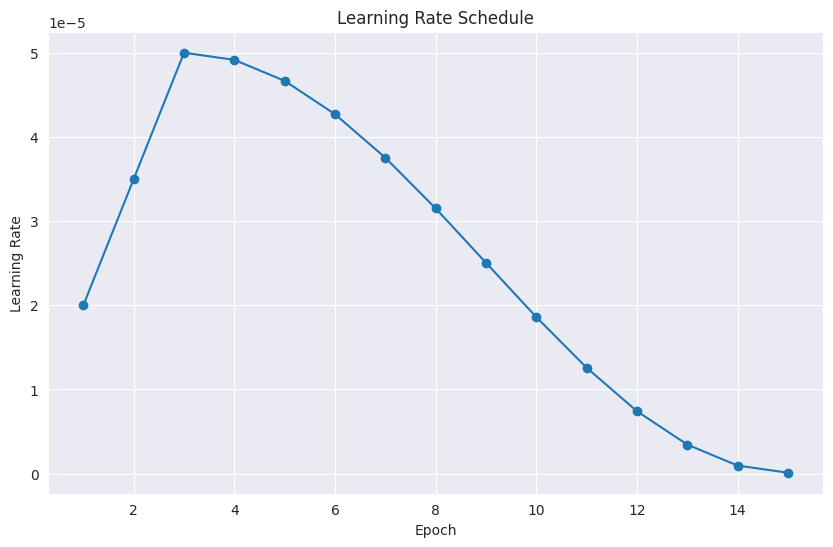

In [79]:
plot_learning_rate_scheduling(
    num_epochs=config.num_epochs,
    num_warmup_epochs=config.scheduler.warmup_epochs,
    linear_start_factor=config.scheduler.linear_start_factor,
    linear_end_factor=config.scheduler.linear_end_factor,
    base_lr=config.lr,
    eta_min=config.scheduler.eta_min,
)

Create empty array to store dataset accuracies for each experiment.

In [80]:
resisc45_accs = []
food101_accs = []
fer2013_accs = []
pcam_accs = []
sun397_accs = []
dtd_accs = []

### Fine-tuning with data augmentation


Train the entire model and all of its parameters on a new dataset.

#### RESISC45

In [81]:
vit_resisc45 = Backbone(
    model_names["ViT"],
    num_classes=len(resisc45_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([45]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([45, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [82]:
get_model_params(vit_resisc45)

Parameters: 85.83M


In [83]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc, _, _, _ = train_model(
    vit_resisc45,
    resisc45_train,
    config,
    "vit",
    val=resisc45_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 99/99 [00:14<00:00,  6.64it/s]


Epochs: 1/15 | train_loss: 3.3897 | train_acc: 0.1576 | val_loss: 2.4442 | val_acc: 0.5822


100%|██████████| 99/99 [00:15<00:00,  6.45it/s]


Epochs: 2/15 | train_loss: 1.1511 | train_acc: 0.7535 | val_loss: 0.3623 | val_acc: 0.9186


100%|██████████| 99/99 [00:14<00:00,  6.70it/s]


Epochs: 3/15 | train_loss: 0.3105 | train_acc: 0.9205 | val_loss: 0.1989 | val_acc: 0.9398


100%|██████████| 99/99 [00:15<00:00,  6.53it/s]


Epochs: 4/15 | train_loss: 0.1321 | train_acc: 0.9648 | val_loss: 0.2051 | val_acc: 0.9365


100%|██████████| 99/99 [00:15<00:00,  6.47it/s]


Epochs: 5/15 | train_loss: 0.0499 | train_acc: 0.9875 | val_loss: 0.1625 | val_acc: 0.9500


100%|██████████| 99/99 [00:14<00:00,  6.68it/s]


Epochs: 6/15 | train_loss: 0.0176 | train_acc: 0.9967 | val_loss: 0.1804 | val_acc: 0.9511


100%|██████████| 99/99 [00:14<00:00,  6.66it/s]


Epochs: 7/15 | train_loss: 0.0091 | train_acc: 0.9983 | val_loss: 0.2106 | val_acc: 0.9457


100%|██████████| 99/99 [00:15<00:00,  6.42it/s]


Epochs: 8/15 | train_loss: 0.0055 | train_acc: 0.9991 | val_loss: 0.1571 | val_acc: 0.9595


100%|██████████| 99/99 [00:15<00:00,  6.39it/s]


Epochs: 9/15 | train_loss: 0.0021 | train_acc: 0.9999 | val_loss: 0.1516 | val_acc: 0.9617


100%|██████████| 99/99 [00:15<00:00,  6.32it/s]


Epochs: 10/15 | train_loss: 0.0011 | train_acc: 1.0000 | val_loss: 0.1549 | val_acc: 0.9608


100%|██████████| 99/99 [00:15<00:00,  6.44it/s]


Epochs: 11/15 | train_loss: 0.0009 | train_acc: 1.0000 | val_loss: 0.1557 | val_acc: 0.9616


100%|██████████| 99/99 [00:15<00:00,  6.48it/s]


Epochs: 12/15 | train_loss: 0.0008 | train_acc: 1.0000 | val_loss: 0.1564 | val_acc: 0.9611


100%|██████████| 99/99 [00:14<00:00,  6.71it/s]


Epochs: 13/15 | train_loss: 0.0008 | train_acc: 1.0000 | val_loss: 0.1570 | val_acc: 0.9611


100%|██████████| 99/99 [00:15<00:00,  6.55it/s]

Epochs: 14/15 | train_loss: 0.0007 | train_acc: 1.0000 | val_loss: 0.1576 | val_acc: 0.9610
Early stopping triggered. Stopping training and saving the model...


In [84]:
resisc45_loss, resisc45_acc, resisc45_per_class_acc = evaluate_model(
    vit_resisc45, resisc45_test, config
)

100%|██████████| 99/99 [00:15<00:00,  6.57it/s]

test_loss: 0.1879 | test_acc: 0.9567


In [85]:
resisc45_accs.append(resisc45_acc)

In [86]:
get_top_5_accuracies(resisc45_per_class_acc)

[('airplane', 1.0),
 ('baseball diamond', 1.0),
 ('chaparral', 1.0),
 ('harbor', 0.9929577464788732),
 ('ship', 0.9925925925925926)]

In [87]:
get_bottom_5_accuracies(resisc45_per_class_acc)

[('palace', 0.7928571428571428),
 ('railway station', 0.8896103896103896),
 ('terrace', 0.9133858267716536),
 ('wetland', 0.9152542372881356),
 ('church', 0.916083916083916)]

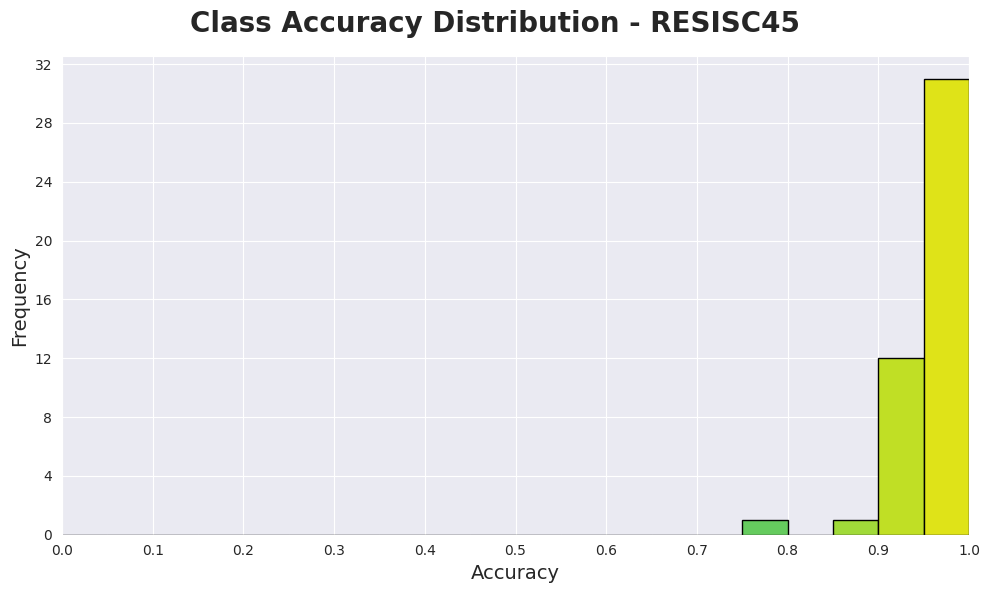

In [88]:
plot_per_class_accuracies(resisc45_per_class_acc, "RESISC45", num_bins=20)

#### Food-101

In [89]:
vit_food101 = Backbone(
    model_names["ViT"], 
    num_classes=len(food101_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([101]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([101, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [91]:
get_model_params(vit_food101)

Parameters: 85.88M


In [92]:
food101_loss, food101_acc, food101_per_class_acc, _, _, _ = train_model(
    vit_food101,
    food101_train,
    config,
    "vit",
    val=food101_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

 91%|█████████▏| 830/908 [05:20<00:27,  2.84it/s]/usr/local/lib/python3.10/dist-packages/PIL/TiffImagePlugin.py:900: UserWarning: Truncated File Read
  warnings.warn(str(msg))
100%|██████████| 395/395 [01:45<00:00,  3.74it/s]


Epochs: 1/15 | train_loss: 4.1569 | train_acc: 0.1226 | val_loss: 3.1277 | val_acc: 0.5039


100%|██████████| 395/395 [01:36<00:00,  4.10it/s]


Epochs: 2/15 | train_loss: 1.8904 | train_acc: 0.6166 | val_loss: 0.9662 | val_acc: 0.7885


100%|██████████| 908/908 [05:00<00:00,  3.02it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 395/395 [01:40<00:00,  3.92it/s]


Epochs: 3/15 | train_loss: 0.9008 | train_acc: 0.7850 | val_loss: 0.6956 | val_acc: 0.8235


100%|██████████| 395/395 [01:40<00:00,  3.91it/s]


Epochs: 4/15 | train_loss: 0.5246 | train_acc: 0.8694 | val_loss: 0.6727 | val_acc: 0.8262


100%|██████████| 395/395 [01:41<00:00,  3.89it/s]


Epochs: 5/15 | train_loss: 0.2722 | train_acc: 0.9325 | val_loss: 0.6824 | val_acc: 0.8295


100%|██████████| 395/395 [01:41<00:00,  3.89it/s]


Epochs: 6/15 | train_loss: 0.1403 | train_acc: 0.9667 | val_loss: 0.7376 | val_acc: 0.8247


100%|██████████| 395/395 [01:40<00:00,  3.93it/s]


Epochs: 7/15 | train_loss: 0.0698 | train_acc: 0.9845 | val_loss: 0.7950 | val_acc: 0.8239


100%|██████████| 395/395 [01:40<00:00,  3.95it/s]


Epochs: 8/15 | train_loss: 0.0333 | train_acc: 0.9932 | val_loss: 0.8240 | val_acc: 0.8250


100%|██████████| 395/395 [01:43<00:00,  3.81it/s]

Epochs: 9/15 | train_loss: 0.0153 | train_acc: 0.9971 | val_loss: 0.8419 | val_acc: 0.8260
Early stopping triggered. Stopping training and saving the model...


In [93]:
food101_loss, food101_acc, food101_per_class_acc = evaluate_model(
    vit_food101, food101_validation, config
)

100%|██████████| 395/395 [01:49<00:00,  3.59it/s]

test_loss: 0.8419 | test_acc: 0.8260


In [94]:
food101_accs.append(food101_acc)

In [95]:
get_top_5_accuracies(food101_per_class_acc)

[('edamame', 0.9711934156378601),
 ('pad thai', 0.9380165289256198),
 ('macarons', 0.9291666666666667),
 ('deviled eggs', 0.9282868525896414),
 ('spaghetti bolognese', 0.928)]

In [96]:
get_bottom_5_accuracies(food101_per_class_acc)

[('steak', 0.48659003831417624),
 ('baby back ribs', 0.6062992125984252),
 ('filet mignon', 0.6338582677165354),
 ('bread pudding', 0.676923076923077),
 ('lasagna', 0.6825396825396826)]

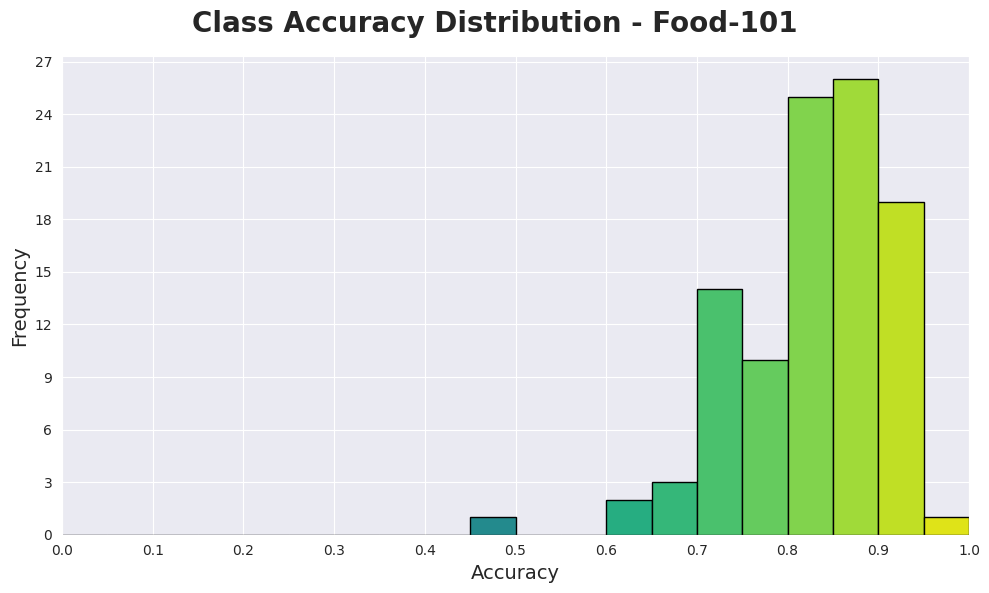

In [97]:
plot_per_class_accuracies(food101_per_class_acc, "Food-101", num_bins=20)

#### FER2013

In [98]:
vit_fer2013 = Backbone(
    model_names["ViT"], 
    num_classes=len(fer2013_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([7]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([7, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [99]:
get_model_params(vit_fer2013)

Parameters: 85.80M


In [100]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc, _, _, _ = train_model(
    vit_fer2013,
    fer2013_train,
    config,
    "vit",
    val=fer2013_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 57/57 [00:06<00:00,  8.56it/s]


Epochs: 1/15 | train_loss: 1.4785 | train_acc: 0.4277 | val_loss: 1.1182 | val_acc: 0.5809


100%|██████████| 57/57 [00:06<00:00,  8.66it/s]


Epochs: 2/15 | train_loss: 1.1155 | train_acc: 0.5822 | val_loss: 0.9503 | val_acc: 0.6486


100%|██████████| 516/516 [01:48<00:00,  4.75it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 57/57 [00:06<00:00,  8.64it/s]


Epochs: 3/15 | train_loss: 0.9324 | train_acc: 0.6559 | val_loss: 0.8961 | val_acc: 0.6723


100%|██████████| 57/57 [00:06<00:00,  8.64it/s]


Epochs: 4/15 | train_loss: 0.7719 | train_acc: 0.7179 | val_loss: 0.8963 | val_acc: 0.6790


100%|██████████| 57/57 [00:06<00:00,  8.49it/s]


Epochs: 5/15 | train_loss: 0.5358 | train_acc: 0.8106 | val_loss: 0.9420 | val_acc: 0.6963


100%|██████████| 57/57 [00:06<00:00,  8.59it/s]


Epochs: 6/15 | train_loss: 0.3126 | train_acc: 0.8926 | val_loss: 1.0349 | val_acc: 0.6985


100%|██████████| 57/57 [00:06<00:00,  8.62it/s]


Epochs: 7/15 | train_loss: 0.1592 | train_acc: 0.9506 | val_loss: 1.2341 | val_acc: 0.7044


100%|██████████| 57/57 [00:06<00:00,  8.57it/s]

Epochs: 8/15 | train_loss: 0.0797 | train_acc: 0.9756 | val_loss: 1.4054 | val_acc: 0.6994
Early stopping triggered. Stopping training and saving the model...


In [101]:
fer2013_loss, fer2013_acc, fer2013_per_class_acc = evaluate_model(
    vit_fer2013, fer2013_test, config
)

100%|██████████| 57/57 [00:06<00:00,  8.52it/s]

test_loss: 1.3455 | test_acc: 0.7055


In [102]:
fer2013_accs.append(fer2013_acc)

In [103]:
fer2013_per_class_acc

{'angry': 0.5682281059063137,
 'disgust': 0.7272727272727273,
 'fear': 0.5643939393939394,
 'happy': 0.8748577929465301,
 'sad': 0.632996632996633,
 'surprise': 0.7836538461538461,
 'neutral': 0.7092651757188498}

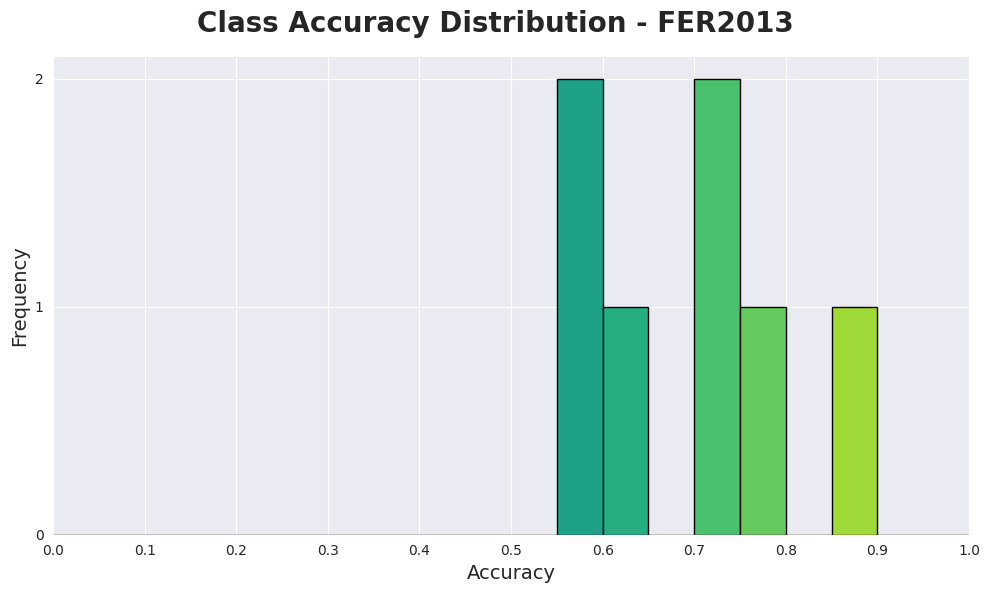

In [104]:
plot_per_class_accuracies(fer2013_per_class_acc, "FER2013", num_bins=20)

#### PCam

In [105]:
vit_pcam = Backbone(
    model_names["ViT"], 
    num_classes=len(pcam_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([2]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([2, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [106]:
get_model_params(vit_pcam)

Parameters: 85.80M


In [107]:
pcam_loss, pcam_acc, pcam_per_class_acc, _, _, _ = train_model(
    vit_pcam,
    pcam_train,
    config,
    "vit",
    val=pcam_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 512/512 [01:04<00:00,  7.88it/s]


Epochs: 1/15 | train_loss: 0.1879 | train_acc: 0.9264 | val_loss: 0.3359 | val_acc: 0.8914


100%|██████████| 512/512 [01:04<00:00,  7.93it/s]


Epochs: 2/15 | train_loss: 0.1210 | train_acc: 0.9566 | val_loss: 0.3909 | val_acc: 0.8835


100%|██████████| 4711/4711 [18:07<00:00,  4.33it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 512/512 [01:04<00:00,  7.93it/s]


Epochs: 3/15 | train_loss: 0.0859 | train_acc: 0.9700 | val_loss: 0.4953 | val_acc: 0.8552


100%|██████████| 512/512 [01:04<00:00,  8.00it/s]


Epochs: 4/15 | train_loss: 0.0652 | train_acc: 0.9773 | val_loss: 0.3576 | val_acc: 0.9020


100%|██████████| 512/512 [01:04<00:00,  8.00it/s]


Epochs: 5/15 | train_loss: 0.0411 | train_acc: 0.9859 | val_loss: 0.5424 | val_acc: 0.8828


100%|██████████| 512/512 [01:04<00:00,  7.96it/s]

Epochs: 6/15 | train_loss: 0.0266 | train_acc: 0.9910 | val_loss: 0.5906 | val_acc: 0.8914
Early stopping triggered. Stopping training and saving the model...


In [108]:
pcam_loss, pcam_acc, pcam_per_class_acc = evaluate_model(vit_pcam, pcam_test, config)

100%|██████████| 512/512 [01:04<00:00,  7.99it/s]

test_loss: 0.6484 | test_acc: 0.8670


In [109]:
pcam_accs.append(pcam_acc)

In [110]:
pcam_per_class_acc

{'healthy lymph node tissue': 0.9851747910438655,
 'lymph node tumor tissue': 0.7486719179336875}

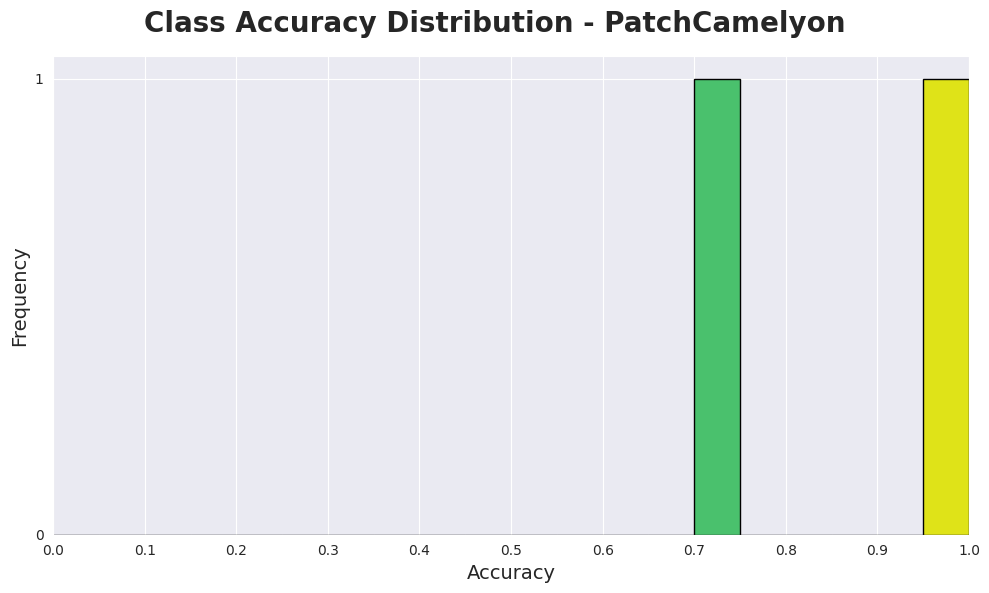

In [111]:
plot_per_class_accuracies(pcam_per_class_acc, "PatchCamelyon", num_bins=20)

#### SUN397

In [112]:
vit_sun397 = Backbone(
    model_names["ViT"], 
    num_classes=len(sun397_train.get_labels()),
    dropout=True,
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([397]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([397, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [113]:
get_model_params(vit_sun397)

Parameters: 86.10M


In [114]:
sun397_loss, sun397_acc, sun397_per_class_acc, _, _, _ = train_model(
    vit_sun397,
    sun397_train,
    config,
    "vit",
    val=sun397_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 170/170 [00:54<00:00,  3.12it/s]


Epochs: 1/15 | train_loss: 5.3468 | train_acc: 0.1103 | val_loss: 4.2780 | val_acc: 0.3118


100%|██████████| 170/170 [00:54<00:00,  3.12it/s]


Epochs: 2/15 | train_loss: 2.8959 | train_acc: 0.4738 | val_loss: 1.6708 | val_acc: 0.6602


100%|██████████| 1368/1368 [10:46<00:00,  2.12it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 170/170 [00:54<00:00,  3.10it/s]


Epochs: 3/15 | train_loss: 1.3874 | train_acc: 0.6909 | val_loss: 0.9752 | val_acc: 0.7536


100%|██████████| 170/170 [00:54<00:00,  3.11it/s]


Epochs: 4/15 | train_loss: 0.8066 | train_acc: 0.7945 | val_loss: 0.8450 | val_acc: 0.7652


100%|██████████| 170/170 [00:54<00:00,  3.11it/s]


Epochs: 5/15 | train_loss: 0.4685 | train_acc: 0.8741 | val_loss: 0.8487 | val_acc: 0.7760


100%|██████████| 170/170 [00:54<00:00,  3.10it/s]


Epochs: 6/15 | train_loss: 0.2660 | train_acc: 0.9286 | val_loss: 0.8950 | val_acc: 0.7728


100%|██████████| 170/170 [00:55<00:00,  3.07it/s]


Epochs: 7/15 | train_loss: 0.1439 | train_acc: 0.9622 | val_loss: 1.0016 | val_acc: 0.7656


100%|██████████| 170/170 [00:54<00:00,  3.12it/s]


Epochs: 8/15 | train_loss: 0.0738 | train_acc: 0.9825 | val_loss: 1.0194 | val_acc: 0.7724


100%|██████████| 170/170 [00:54<00:00,  3.10it/s]

Epochs: 9/15 | train_loss: 0.0358 | train_acc: 0.9924 | val_loss: 1.0745 | val_acc: 0.7725
Early stopping triggered. Stopping training and saving the model...


In [115]:
sun397_loss, sun397_acc, sun397_per_class_acc = evaluate_model(
    vit_sun397, sun397_test, config
)

100%|██████████| 340/340 [01:49<00:00,  3.09it/s]


test_loss: 1.0753 | test_acc: 0.7710


In [116]:
sun397_accs.append(sun397_acc)

In [117]:
get_top_5_accuracies(sun397_per_class_acc)

[('batters box', 1.0),
 ('bullring', 1.0),
 ('greenhouse (outdoor)', 1.0),
 ('sauna', 1.0),
 ('underwater (coral reef)', 1.0)]

In [118]:
get_bottom_5_accuracies(sun397_per_class_acc)

[('recreation room', 0.07407407407407407),
 ('biology laboratory', 0.13636363636363635),
 ('bistro (indoor)', 0.15789473684210525),
 ('inn (outdoor)', 0.20689655172413793),
 ('power plant (outdoor)', 0.23333333333333334)]

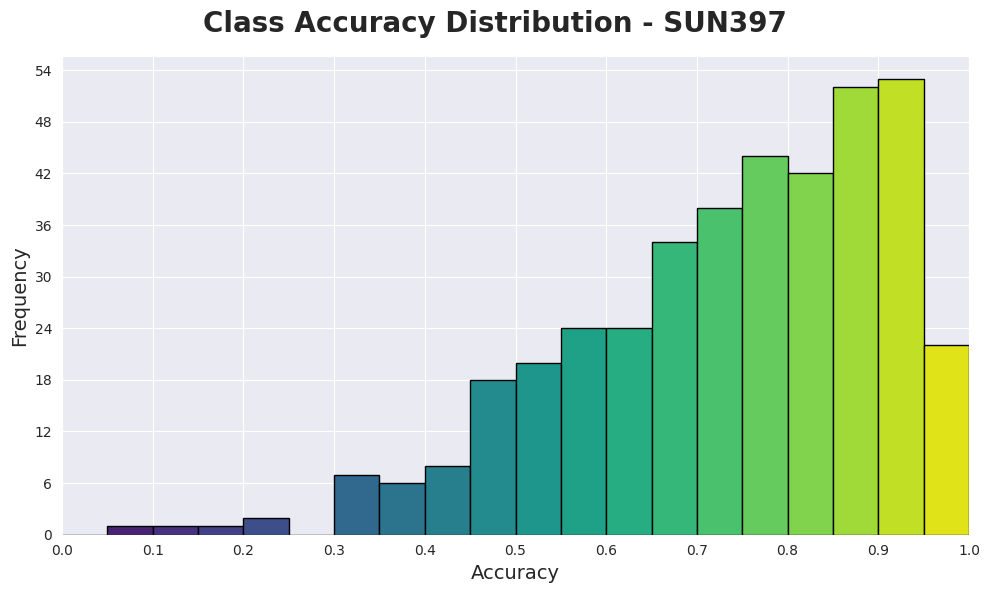

In [119]:
plot_per_class_accuracies(sun397_per_class_acc, "SUN397", num_bins=20)

#### DTD

In [120]:
vit_dtd = Backbone(
    model_names["ViT"], 
    num_classes=len(dtd_train.get_labels()), 
    dropout=True, 
    dropout_rate=config.dropout_rate
)

Some weights of ViTForImageClassification were not initialized from the model checkpoint at google/vit-base-patch16-224 and are newly initialized because the shapes did not match:
- classifier.bias: found shape torch.Size([1000]) in the checkpoint and torch.Size([47]) in the model instantiated
- classifier.weight: found shape torch.Size([1000, 768]) in the checkpoint and torch.Size([47, 768]) in the model instantiated
You should probably TRAIN this model on a down-stream task to be able to use it for predictions and inference.


In [121]:
get_model_params(vit_dtd)

Parameters: 85.83M


In [122]:
dtd_loss, dtd_acc, dtd_per_class_acc, _, _, _ = train_model(
    vit_dtd,
    dtd_train,
    config,
    "vit",
    val=dtd_validation,
    use_val=True,
    fine_tune=True,
    use_early_stopping=config.early_stopping.enabled,
    gradient_clipping=config.gradient_clipping.enabled,
    scheduling=config.scheduler.enabled,
)

100%|██████████| 6/6 [00:02<00:00,  2.95it/s]


Epochs: 1/15 | train_loss: 4.0350 | train_acc: 0.0267 | val_loss: 3.7950 | val_acc: 0.0319


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epochs: 2/15 | train_loss: 3.5578 | train_acc: 0.1169 | val_loss: 3.1274 | val_acc: 0.3138


100%|██████████| 61/61 [00:25<00:00,  2.42it/s]
/usr/local/lib/python3.10/dist-packages/torch/optim/lr_scheduler.py:240: UserWarning: The epoch parameter in `scheduler.step()` was not necessary and is being deprecated where possible. Please use `scheduler.step()` to step the scheduler. During the deprecation, if epoch is different from None, the closed form is used instead of the new chainable form, where available. Please open an issue if you are unable to replicate your use case: https://github.com/pytorch/pytorch/issues/new/choose.
  warnings.warn(EPOCH_DEPRECATION_WARNING, UserWarning)
100%|██████████| 6/6 [00:01<00:00,  3.14it/s]


Epochs: 3/15 | train_loss: 2.5602 | train_acc: 0.4451 | val_loss: 1.9912 | val_acc: 0.6676


100%|██████████| 6/6 [00:01<00:00,  3.04it/s]


Epochs: 4/15 | train_loss: 1.4224 | train_acc: 0.7209 | val_loss: 1.1909 | val_acc: 0.7606


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epochs: 5/15 | train_loss: 0.6914 | train_acc: 0.8782 | val_loss: 0.8709 | val_acc: 0.7979


100%|██████████| 6/6 [00:01<00:00,  3.19it/s]


Epochs: 6/15 | train_loss: 0.3231 | train_acc: 0.9589 | val_loss: 0.8035 | val_acc: 0.7766


100%|██████████| 6/6 [00:01<00:00,  3.08it/s]


Epochs: 7/15 | train_loss: 0.1382 | train_acc: 0.9905 | val_loss: 0.7102 | val_acc: 0.8165


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epochs: 8/15 | train_loss: 0.0594 | train_acc: 0.9992 | val_loss: 0.6823 | val_acc: 0.8138


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epochs: 9/15 | train_loss: 0.0331 | train_acc: 1.0000 | val_loss: 0.6731 | val_acc: 0.8085


100%|██████████| 6/6 [00:02<00:00,  2.99it/s]


Epochs: 10/15 | train_loss: 0.0237 | train_acc: 1.0000 | val_loss: 0.6753 | val_acc: 0.8271


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]


Epochs: 11/15 | train_loss: 0.0193 | train_acc: 1.0000 | val_loss: 0.6761 | val_acc: 0.8271


100%|██████████| 6/6 [00:01<00:00,  3.16it/s]


Epochs: 12/15 | train_loss: 0.0166 | train_acc: 1.0000 | val_loss: 0.6787 | val_acc: 0.8271


100%|██████████| 6/6 [00:01<00:00,  3.05it/s]


Epochs: 13/15 | train_loss: 0.0158 | train_acc: 1.0000 | val_loss: 0.6802 | val_acc: 0.8298


100%|██████████| 6/6 [00:01<00:00,  3.07it/s]

Epochs: 14/15 | train_loss: 0.0152 | train_acc: 1.0000 | val_loss: 0.6818 | val_acc: 0.8271
Early stopping triggered. Stopping training and saving the model...


In [123]:
dtd_loss, dtd_acc, dtd_per_class_acc = evaluate_model(vit_dtd, dtd_test, config)

100%|██████████| 30/30 [00:07<00:00,  3.77it/s]

test_loss: 0.8161 | test_acc: 0.7846


In [124]:
dtd_accs.append(dtd_acc)

In [125]:
get_top_5_accuracies(dtd_per_class_acc)

[('crystalline', 0.975),
 ('knitted', 0.975),
 ('zigzagged', 0.975),
 ('cobwebbed', 0.95),
 ('scaly', 0.95)]

In [126]:
get_bottom_5_accuracies(dtd_per_class_acc)

[('blotchy', 0.475),
 ('stained', 0.5),
 ('woven', 0.55),
 ('pitted', 0.6),
 ('porous', 0.625)]

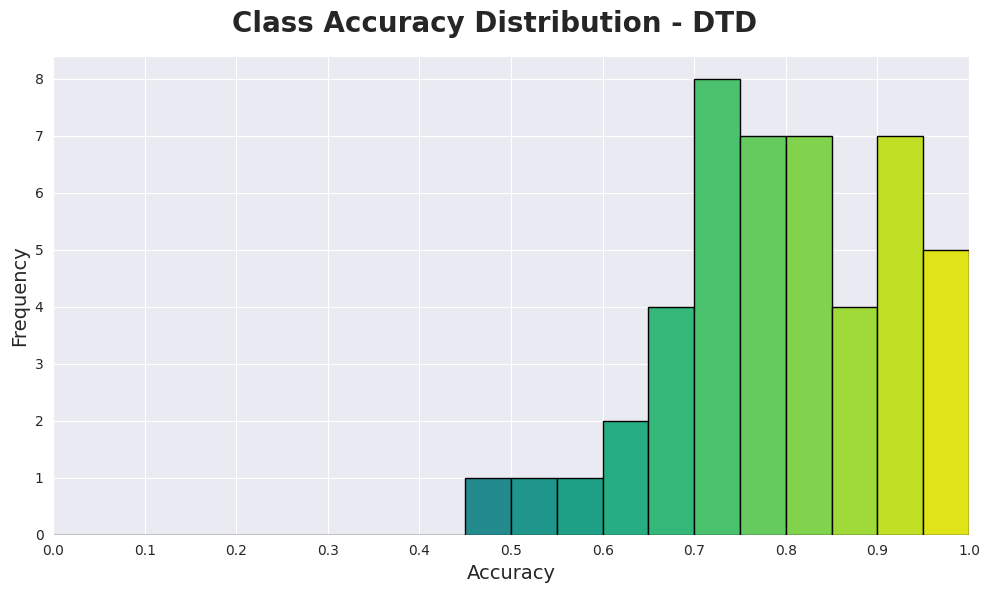

In [127]:
plot_per_class_accuracies(dtd_per_class_acc, "DTD", num_bins=20)

### Results

Display the results of the analysis in dataframe.

In [128]:
results = [
    resisc45_accs,
    food101_accs,
    fer2013_accs,
    pcam_accs,
    sun397_accs,
    dtd_accs,
]

In [129]:
labels = ["RESISC45", "Food-101", "FER2013", "PatchCamelyon", "SUN397", "DTD"]

In [130]:
acc_dict = create_accuracy_dict(results, labels)

In [131]:
df = pd.DataFrame(results, columns=["fine-tuning with data augmentations"], index=labels)
df

,fine-tuning with data augmentations
RESISC45,0.956667
Food-101,0.825966
FER2013,0.705489
PatchCamelyon,0.866974
SUN397,0.771034
DTD,0.784574
